In [34]:
# load stuff
import json
import random
import time
import os
import pandas as pd
import re
from wordcloud import WordCloud
import ast

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim.corpora as corpora

from pprint import pprint

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# requires scipy==1.9.3 to use gensim


[nltk_data] Downloading package stopwords to /home/zoe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
# import data (plots)
# want to load data into a pandas dataframe where one column in the 

# function copied from the textanalysis.py file
def import_summaries_data(filename: str) -> pd.DataFrame:
    """Function to import the summaries data

    Args:
        filename (str): name of file with summaries

    Returns:
        pd.DataFrame: dataframe where the index is the film id and has the summaries
    """
    raw_data_folder = "./data/raw_data/"
    summaries = pd.read_csv(
        raw_data_folder + filename, sep="\t", index_col=0, names=["index", "summary"]
    )
    return summaries

summaries = import_summaries_data("plot_summaries.txt")



In [36]:
summaries_war = pd.read_csv("../war_action_movies_with_persons_1.csv")
summaries_war.head()

,name,release_date,revenue,runtime,languages,country,genres,plot,Persona
0,The Birth of a Nation,1915.0,50000000.0,190.0,"Silent film, English",United States of America,"Silent film, Indie, Costume drama, Epic, Black...",The film follows two juxtaposed families: the...,"{'Ben Cameron': {'guilty', 'leading', 'holds',..."
1,Barry Lyndon,1975.0,20000000.0,187.0,"French , English , German","United States of America, United Kingdom","Costume drama, Film adaptation, Period piece, ...",:By What Means Redmond Barry Acquired the Sty...,"{'Redmond Barry': {'decides', 'reveals', 'refu..."
2,Braveheart,1995.0,211409945.0,175.0,"French , Latin , English , Gaelic",United States of America,"Biography, Adventure, History, War film, Actio...","In the 13th century, after several years of po...","{'Longshanks': {'implores', 'seeks', 'sees', '..."
3,Das Boot,1981.0,84970337.0,210.0,"French , English , German","West Germany, Germany","Thriller, World cinema, History, Action/Advent...",The story is told from the viewpoint of Lt. We...,"{'Thomsen': {'lands', 'gives'}, 'Werner': {'mo..."
4,Full Metal Jacket,1987.0,46300000.0,112.0,"Vietnamese , English","United States of America, United Kingdom","Anti-war, War film, Period piece, Drama, Film ...","In 1967, during the Vietnam War, a group of ne...","{'Hartman': {'discovers', 'confronts', 'adopts..."


In [37]:
summaries.head()

,summary
index,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


In [38]:
summaries = summaries.head(8000)


# Remove punctuation
summaries['summary_clean'] = summaries['summary'].map(lambda x: re.sub('[,.!?]', '', x))

# Convert the titles to lowercase
# do this for test but should also try without removing capitalisation
summaries["summary_clean"] = summaries['summary_clean'].map(lambda x: x.lower())

# Print out the first rows of papers
summaries.head()




,summary,summary_clean
index,,
23890098,"Shlykov, a hard-working taxi driver and Lyosha...",shlykov a hard-working taxi driver and lyosha ...
31186339,The nation of Panem consists of a wealthy Capi...,the nation of panem consists of a wealthy capi...
20663735,Poovalli Induchoodan is sentenced for six yea...,poovalli induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,...",the lemon drop kid a new york city swindler i...
595909,Seventh-day Adventist Church pastor Michael Ch...,seventh-day adventist church pastor michael ch...


In [39]:


# Remove punctuation
# summaries_war['personas_clean'] = summaries_war['Persona'].map(lambda x: re.sub(r"[{}':,.!?]", '', x))

# # Convert the titles to lowercase
# # do this for test but should also try without removing capitalisation
# summaries_war["personas_clean"] = summaries_war['personas_clean'].map(lambda x: x.lower())

# # Print out the first rows of papers
# summaries_war.head()

# # here the personas are all 

# print(summaries_war.loc[1,"Persona"])

In [44]:
import pandas as pd



# Create an empty list to hold the new rows
new_rows = []

# Iterate over each row in the DataFrame
for index, row in summaries_war.iterrows():
    persona_dict = ast.literal_eval(row['Persona'])
    for persona, actions in persona_dict.items():
        # Copy the row and replace the 'character_actions' with the current character's data
        new_row = row.drop('Persona')  # Remove the old 'character_actions' column
        persona_series = pd.Series({
            'persona': persona,      # Add the persona name
            'actions': actions       # Add the actions
        })
        new_row = pd.concat([new_row, persona_series])
        new_rows.append(new_row)

# Convert the list of new rows into a new DataFrame
summaries_war2 = pd.DataFrame(new_rows)

summaries_war2['actions_clean'] = summaries_war2['actions'].map(lambda x: re.sub(r"[{}':,.!?]", '', ' '.join(x)))
# summaries_war2["actions_clean"] = summaries_war2['actions_clean'].map(lambda x: x.lower())


# Display the new DataFrame
summaries_war2.head()

,name,release_date,revenue,runtime,languages,country,genres,plot,persona,actions,actions_clean
0,The Birth of a Nation,1915.0,50000000.0,190.0,"Silent film, English",United States of America,"Silent film, Indie, Costume drama, Epic, Black...",The film follows two juxtaposed families: the...,Ben Cameron,"{fights, persuades, holds, finds, idolizes, te...",fights persuades holds finds idolizes tells ma...
1,The Birth of a Nation,1915.0,50000000.0,190.0,"Silent film, English",United States of America,"Silent film, Indie, Costume drama, Epic, Black...",The film follows two juxtaposed families: the...,Stoneman,"{leaves, go, younger}",leaves go younger
2,The Birth of a Nation,1915.0,50000000.0,190.0,"Silent film, English",United States of America,"Silent film, Indie, Costume drama, Epic, Black...",The film follows two juxtaposed families: the...,Elsie Stoneman,"{jump, breaks, takes, faints, leaps, looking, ...",jump breaks takes faints leaps looking wants g...
3,The Birth of a Nation,1915.0,50000000.0,190.0,"Silent film, English",United States of America,"Silent film, Indie, Costume drama, Epic, Black...",The film follows two juxtaposed families: the...,Griffith,{depicts},depicts
4,The Birth of a Nation,1915.0,50000000.0,190.0,"Silent film, English",United States of America,"Silent film, Indie, Costume drama, Epic, Black...",The film follows two juxtaposed families: the...,Lynch,"{falls, tries, tells, revives}",falls tries tells revives


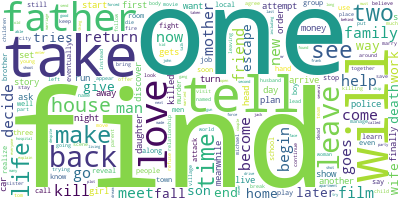

In [ ]:
# Join the different processed titles together.
long_string = ','.join(list(summaries['summary_clean'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()



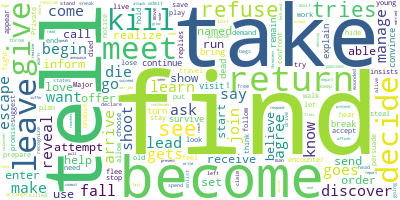

In [45]:
# Join the different processed titles together.
long_string = ','.join(list(summaries_war2['actions_clean'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()


In [26]:
stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = summaries.summary_clean.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['shlykov', 'hard', 'working', 'taxi', 'driver', 'lyosha', 'saxophonist', 'develop', 'bizarre', 'love', 'hate', 'relationship', 'despite', 'prejudices', 'realize', 'different']


In [46]:
stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = summaries_war2.actions_clean.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['fights', 'persuades', 'holds', 'finds', 'idolizes', 'tells', 'make', 'guilty', 'leading', 'rescue']


In [47]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [49]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.021*"takes" + 0.011*"tells" + 0.010*"tries" + 0.009*"go" + 0.009*"leaves" '
  '+ 0.008*"arrives" + 0.008*"returns" + 0.008*"named" + 0.007*"gives" + '
  '0.007*"goes"'),
 (1,
  '0.020*"finds" + 0.017*"takes" + 0.012*"becomes" + 0.011*"decides" + '
  '0.011*"attempts" + 0.009*"asks" + 0.009*"gives" + 0.009*"begins" + '
  '0.008*"tells" + 0.008*"sees"'),
 (2,
  '0.029*"tells" + 0.015*"finds" + 0.012*"becomes" + 0.008*"decides" + '
  '0.007*"shoots" + 0.007*"meets" + 0.007*"refuses" + 0.007*"leads" + '
  '0.006*"returns" + 0.006*"makes"'),
 (3,
  '0.012*"finds" + 0.010*"takes" + 0.010*"tries" + 0.010*"refuses" + '
  '0.010*"tells" + 0.009*"find" + 0.009*"begins" + 0.008*"meets" + '
  '0.008*"sees" + 0.007*"gives"'),
 (4,
  '0.012*"meets" + 0.011*"asks" + 0.011*"tells" + 0.010*"joins" + '
  '0.009*"tries" + 0.009*"finds" + 0.009*"runs" + 0.008*"private" + '
  '0.008*"gives" + 0.008*"helps"'),
 (5,
  '0.013*"refuses" + 0.012*"takes" + 0.010*"goes" + 0.009*"returns" + '
  '0.008*"f

In [51]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.014248  0.009020       1        1  13.115651
1      0.012672  0.046991       2        1  11.739368
6      0.008616 -0.006695       3        1  11.004187
8     -0.011898 -0.017183       4        1  10.785467
4      0.029668 -0.019781       5        1   9.892856
0     -0.007780 -0.068338       6        1   9.783253
9     -0.006665 -0.046052       7        1   8.835653
7      0.102804  0.041844       8        1   8.288730
2     -0.073378  0.082530       9        1   8.279866
5     -0.039790 -0.022335      10        1   8.274970, topic_info=       Term        Freq       Total Category  logprob  loglift
84  returns  210.000000  210.000000  Default  30.0000  30.0000
27    takes  235.000000  235.000000  Default  29.0000  29.0000
9     tells  305.000000  305.000000  Default  28.0000  28.0000
31    falls  121.000000  121.000000  Default  27.0000  27.0000
87  becomes  192.000000  192.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
81   begins    9.670489  111.885445  Topic10  -5.4369   0.0435
26    meets   10.263695  172.942657  Topic10  -5.3773  -0.3324
74     sees    9.619962  138.956098  Topic10  -5.4421  -0.1784
14    comes    8.769999   95.908465  Topic10  -5.5346   0.0999
68    kills    8.735021  132.508847  Topic10  -5.5386  -0.2274

[859 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
170       1  0.126657   able
170       2  0.182949   able
170       3  0.098511   able
170       4  0.140730   able
170       5  0.042219   able
...     ...       ...    ...
321       6  0.162867  young
321       7  0.023267  young
321       8  0.139600  young
321       9  0.209400  young
321      10  0.023267  young

[2250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 7, 9, 5, 1, 10, 8, 3, 6])